Data successfully written to output/1.CST_patch_size_phase_data.csv
Data saved to 2.1.psx_psy_formatted_21x21.csv


<Figure size 1000x600 with 0 Axes>

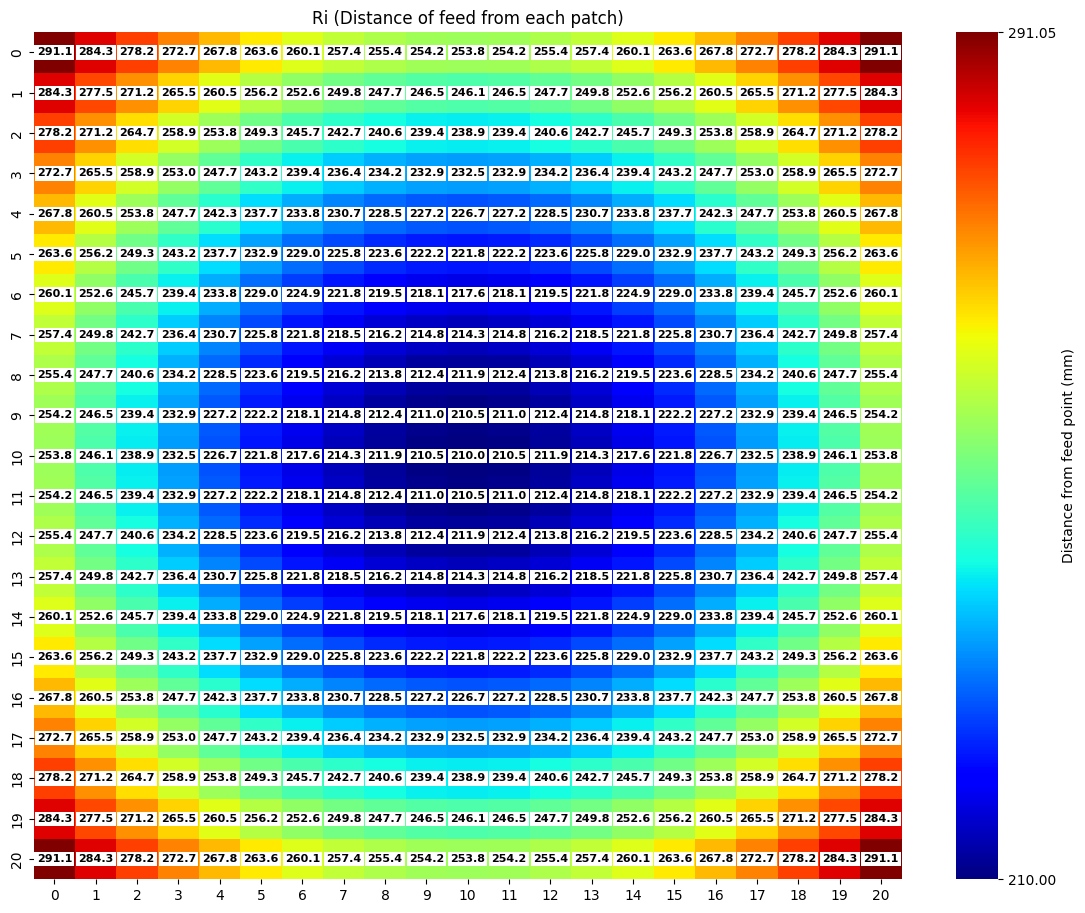

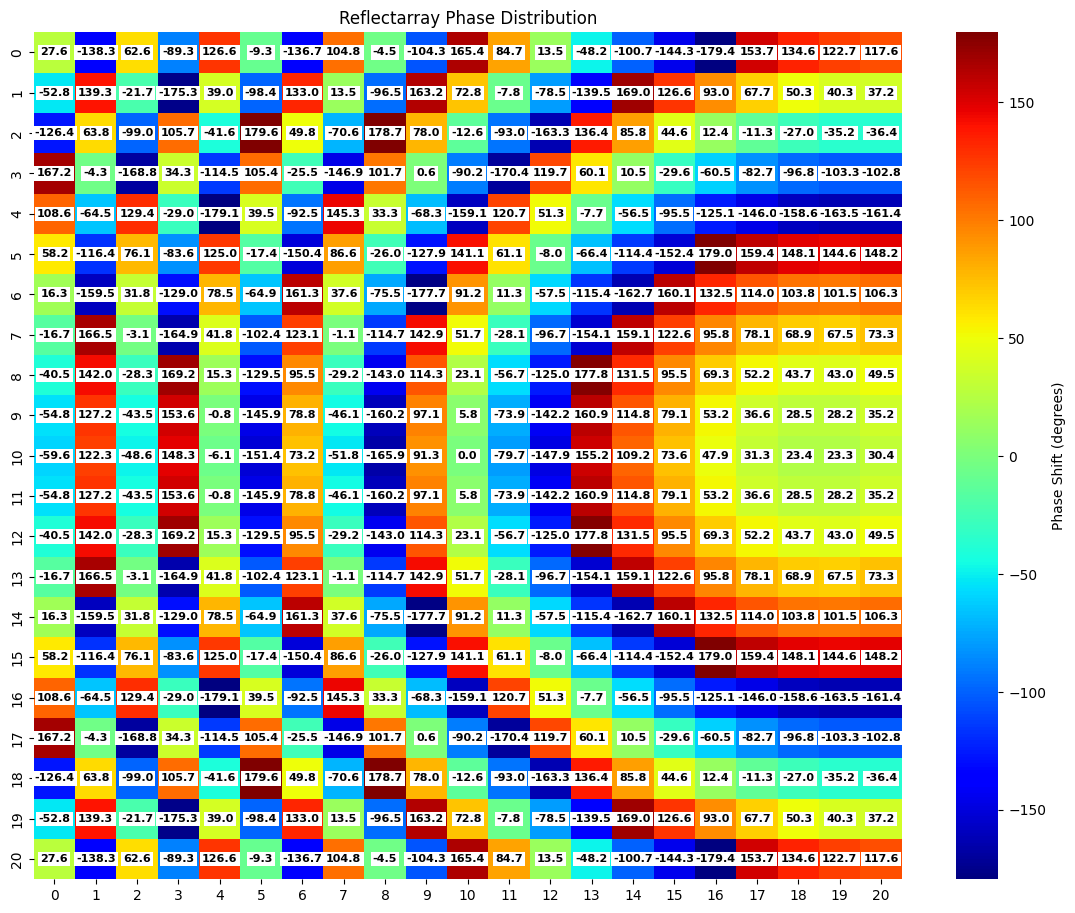

Phase data saved to 2.2phase_distribution.csv
Highest Phase Value: 179.63 degrees
Lowest Phase Value: -179.41 degrees
Patch sizes based on phase distribution saved to 2.3.linear interpolation.csv
Highest Patch Value: 10.24 mm
Lowest Patch Value: 1.62 mm


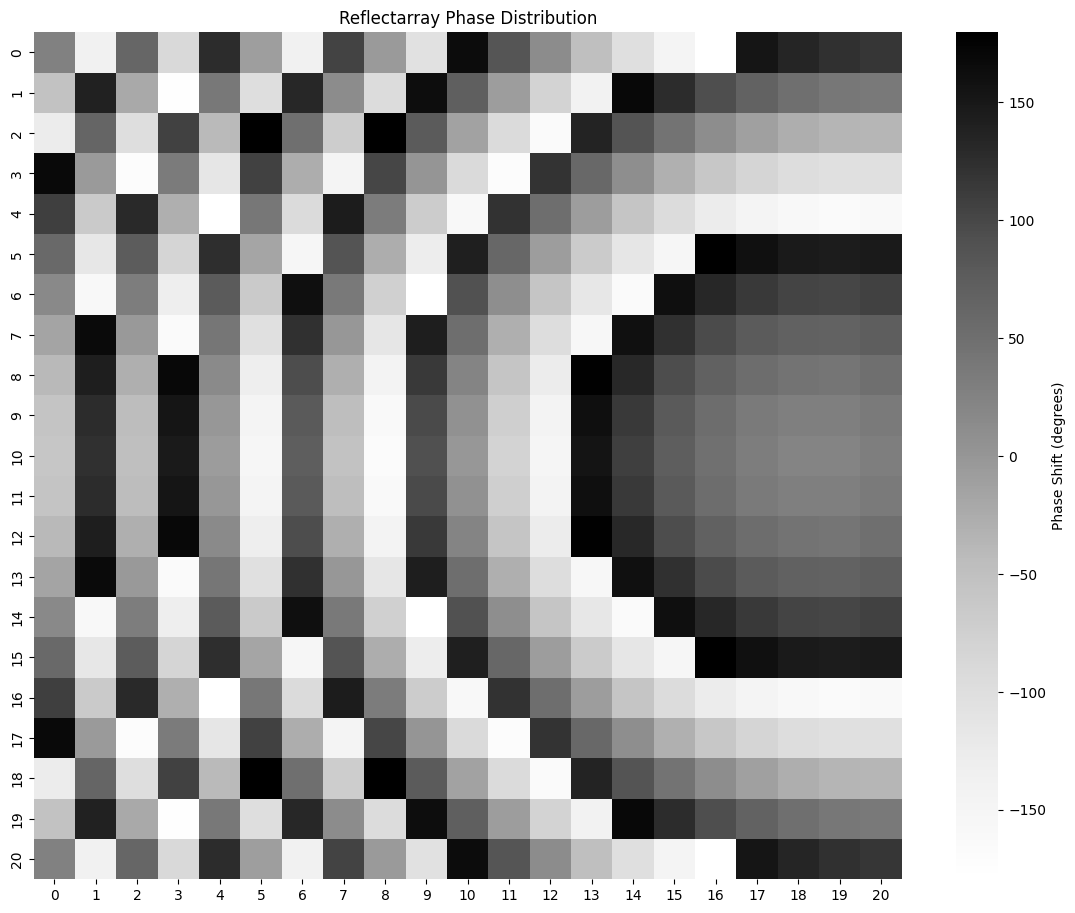

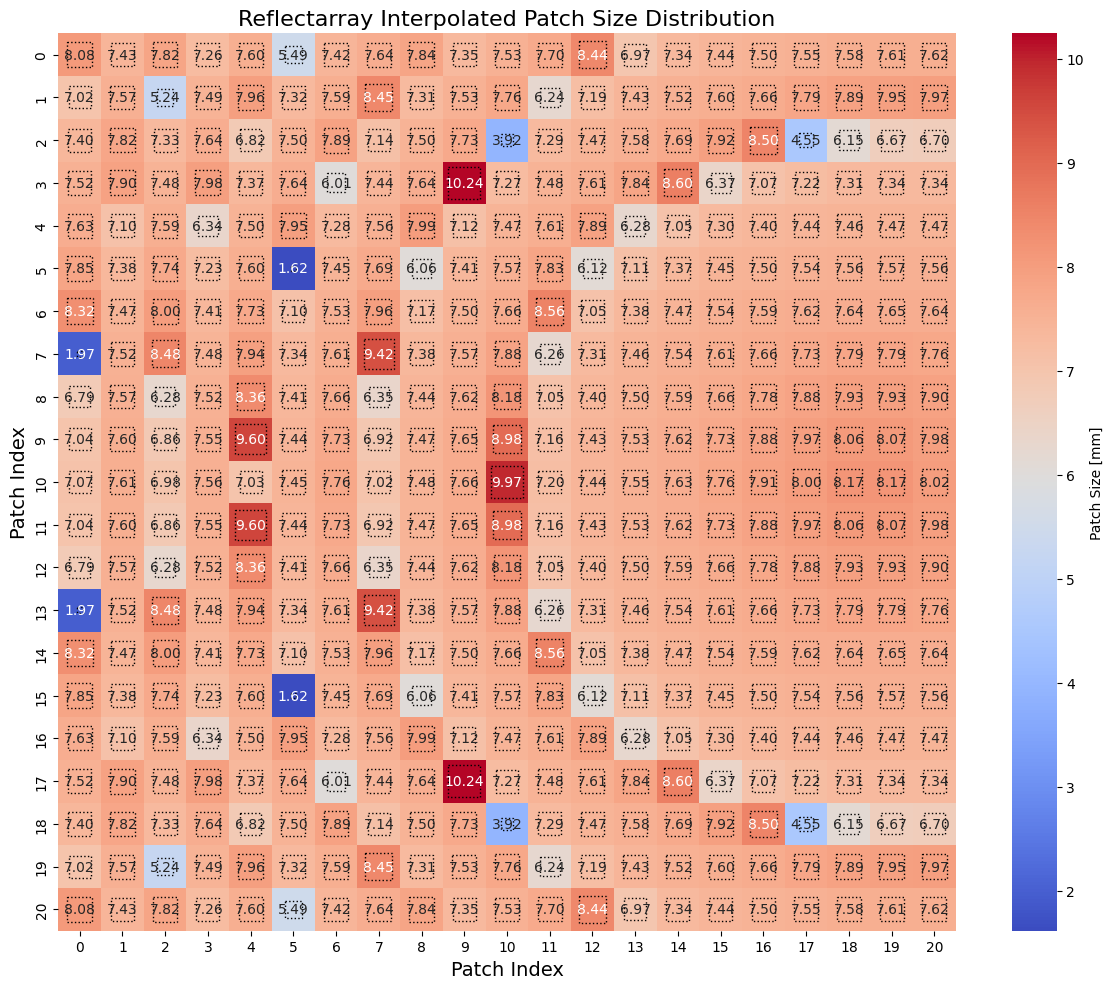

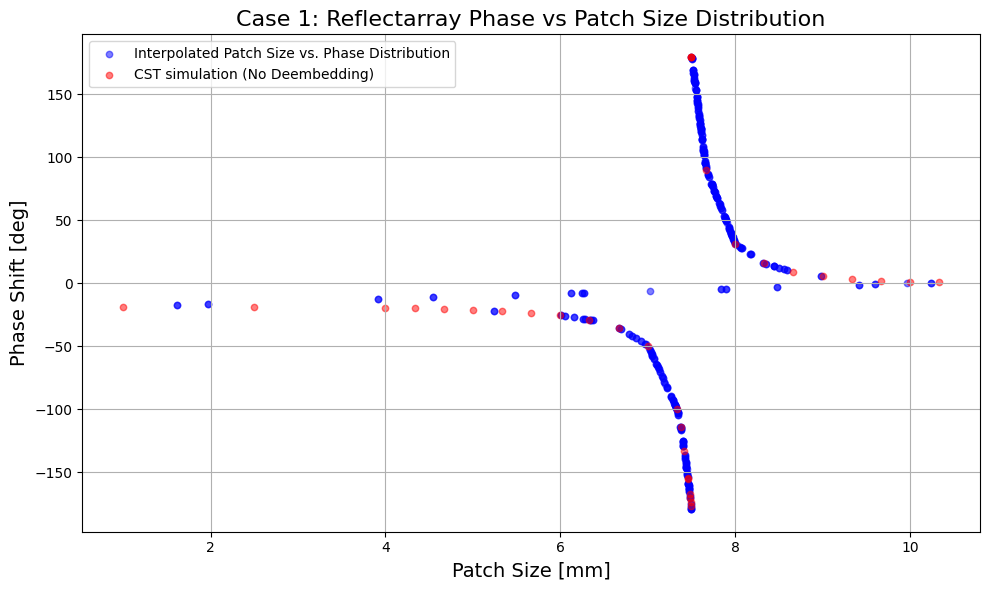

[8.078060755066351, 7.426887438411392, 7.822177248283836, 7.263240077575705, 7.598510982187657, 5.487222768936985, 7.423906379326278, 7.638963208342101, 7.835178075944088, 7.345899724586841, 7.526423678835049, 7.696193627477675, 8.444033968907892, 6.969782476222805, 7.3356928687928065, 7.438221260688107, 7.498365178215235, 7.548160764772597, 7.583729497639737, 7.605764016125136, 7.615120294136527, 7.022031491356691, 7.574944905894095, 5.241844276607392, 7.491947379637226, 7.95637061549236, 7.32357434020454, 7.58666680576761, 8.44583567463016, 7.310714102826328, 7.530467247619143, 7.7639933748636, 6.243638253444335, 7.191711907280925, 7.429091136663962, 7.519805794502793, 7.598540578755128, 7.660983326571734, 7.793020390121587, 7.891959707875493, 7.948831135155909, 7.966426927293357, 7.40211973865185, 7.815182917906354, 7.327469642876797, 7.637330950962802, 6.815557928180289, 7.500004658166375, 7.894545713791922, 7.139618865433185, 7.50174158262367, 7.734506530110845, 3.915603805608166,

In [1]:
import numpy as np
import pandas as pd
from math import sin, cos, pi, radians, degrees
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import csv
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import os
import re

frequency = 10e9 
wavelength_mm = 3e8 / frequency * 1000  
k0 = 2 * pi / wavelength_mm 
spacing = wavelength_mm/2

theta =  30 # Elevation angle in degrees
phi = 0  # Azimuth angle in degrees

feed_point_position_mm = np.array([0, 0, 210])

x_positions_mm = np.linspace(-spacing * 9.5, spacing * 9.5, 21)
y_positions_mm = np.linspace(-spacing * 9.5, spacing * 9.5, 21)

X, Y = np.meshgrid(x_positions_mm, y_positions_mm); 
Z = np.zeros_like(X)

##############################################################################################################
#                                       CST Data

# File paths
file_paths = ['Data.txt','Data1.txt']
output_directory = 'output'
os.makedirs(output_directory, exist_ok=True)

# Initialize a dictionary to store Wp values and corresponding 10 GHz phase shifts for each file
data = {file_path: {'wp_values': [], 'phase_shifts_at_10GHz': []} for file_path in file_paths}

def process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

        found_wp = False

        for line in lines:
            if 'Wp=' in line and not found_wp:
                match = re.search(r'Wp=([\d.]+)', line)
                if match:
                    try:
                        wp_value = float(match.group(1))
                        found_wp = True
                    except ValueError as e:
                        print(f"Could not convert '{match.group(1)}' to float: {e}")

            if found_wp and line.startswith("10.000000000000"):
                parts = line.split()
                if len(parts) > 1:
                    try:
                        phase_shift = float(parts[1])
                        data[file_path]['phase_shifts_at_10GHz'].append(phase_shift)
                        data[file_path]['wp_values'].append(wp_value)
                        found_wp = False
                    except ValueError as e:
                        print(f"Could not convert phase shift value to float: {e}")
                        found_wp = False

        if found_wp:
            print(f"Phase shift for the last Wp value ({wp_value}) not found in {file_path}.")

# Process each file
for file_path in file_paths:
    process_file(file_path)

# Plotting and saving to CSV
plt.figure(figsize=(10, 6))

# Plotting with plotly
fig = go.Figure()

#### OUTPUT-2 ########################################################

# Define CSV file path with the output directory
csv_file_path = os.path.join(output_directory, '1.CST_patch_size_phase_data.csv')

# Write header to CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['File', 'Patch Size (Wp)', 'Phase Shift at 10 GHz'])  # Writing header

    for file_path in file_paths:
        wp_values = data[file_path]['wp_values']
        phase_shifts_at_10GHz = data[file_path]['phase_shifts_at_10GHz']

        if len(wp_values) != len(phase_shifts_at_10GHz):
            print(f"Mismatch in number of Wp values and phase shifts for {file_path}. Please check the input file.")
            continue

        wp_phase_pairs = sorted(zip(wp_values, phase_shifts_at_10GHz), key=lambda pair: pair[0])
        wp_values_sorted, phase_shifts_sorted = zip(*wp_phase_pairs)
        phase_shifts_normalized = [((phase + 180) % 360) - 180 for phase in phase_shifts_sorted]

        # Plotting with plotly
        fig.add_trace(go.Scatter(x=wp_values_sorted, y=phase_shifts_normalized, mode='markers', name=os.path.basename(file_path)))

        # Writing to CSV
        for wp, phase in zip(wp_values_sorted, phase_shifts_normalized):
            writer.writerow([os.path.basename(file_path), wp, phase])  # Writing data rows

#### OUTPUT-3 ########################################################

fig.update_layout(title='No Deembedding: CST Patch Size vs Phase Shift at 10 GHz',
                  xaxis_title='Patch Size [mm]',
                  yaxis_title='Phase Shift [degrees]',
                  legend_title="Files")
fig.show()

# Notify the completion and provide the path to the CSV
print(f'Data successfully written to {csv_file_path}')

##############################################################################################################
#                                       DISTANCE FROM FEED TO PATCH

# Function to calculate distances and plot elements
def calculate_distance_and_plot_elements(X, Y, Z, feed_point, fig):
    distances = np.sqrt((X - feed_point[0])**2 + (Y - feed_point[1])**2 + (Z - feed_point[2])**2)
    fig.add_trace(go.Scatter3d(x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
                               mode='markers', marker=dict(size=2, color='blue'), name='Array Elements',
                               hoverinfo='text',
                               text=[f'x: {x:.2f}, y: {y:.2f}, z: {z:.2f}, Distance: {d:.2f} mm' for x, y, z, d in zip(X.flatten(), Y.flatten(), Z.flatten(), distances.flatten())]))
    for x, y, z, d in zip(X.flatten(), Y.flatten(), Z.flatten(), distances.flatten()):
        fig.add_trace(go.Scatter3d(x=[x, feed_point[0]], y=[y, feed_point[1]], z=[z, feed_point[2]],
                                   mode='lines', line=dict(color='green', width=2), hoverinfo='text',
                                   text=[f'Distance: {d:.2f} mm']))
    return distances
fig = go.Figure()

# Load distance data from CSV file
df = pd.read_csv('2.1.psx_psy_formatted_21x21.csv')
Ri = df.to_numpy(dtype=float)  # Convert DataFrame to numpy array for processing
fig = go.Figure()

# Calculate distances and plot elements
distances = calculate_distance_and_plot_elements(X, Y, Z, feed_point_position_mm, fig)

#### OUTPUT-2 ########################################################

# Add the feed point to the plot
fig.add_trace(go.Scatter3d(x=[feed_point_position_mm[0]], y=[feed_point_position_mm[1]], z=[feed_point_position_mm[2]],
                           mode='markers', marker=dict(size=10, color='red'), name='Feed Point',
                           hoverinfo='text', text=[f'Feed Point\nx: {feed_point_position_mm[0]:.2f}, y: {feed_point_position_mm[1]:.2f}, z: {feed_point_position_mm[2]:.2f}']))

# Update plot layout for elements and feed point location
fig.update_layout(title='3D Plot of Element Positions, Feed Point Location, and Connection Lines',
                  scene=dict(xaxis_title='X Position (mm)', yaxis_title='Y Position (mm)', zaxis_title='Z Position (mm)'),
                  margin=dict(l=0, r=0, b=0, t=30))

#### OUTPUT-3 ########################################################

# Save the calculated distances to CSV
csv_file_path_array = '2.1.psx_psy_formatted_21x21.csv'
with open(csv_file_path_array, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Distance from Feed(mm)'] * 21)  # Header
    for row in distances:
        writer.writerow(row)
print(f"Data saved to {csv_file_path_array}")
fig.show()

#### OUTPUT-4 ########################################################

# Generate the heatmap
df = pd.read_csv(csv_file_path_array)
distances_array = df.to_numpy(dtype=float) # Convert the DataFrame to a 2D array of distances for color mapping
plt.figure(figsize=(14, 11))
ax = sns.heatmap(distances_array, annot=True, fmt=".1f", cmap='jet', cbar_kws={'label': 'Distance from feed point (mm)'})
ax.set_title('Ri (Distance of feed from each patch)')
cbar = ax.collections[0].colorbar
cbar.set_ticks([np.min(distances_array), np.max(distances_array)])
for text in ax.texts:
    text.set_size(8)
    text.set_weight('bold')
    text.set_color('black') 
    text.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))
plt.show()

##############################################################################################################
#                                       PHASE DISTRIBUTION

# Calculate phase shift for all elements in radians
phi_a = k0 * (Ri - np.sin(np.radians(theta)) * (X * np.cos(np.radians(phi)) + Y * np.sin(np.radians(phi))))

# Convert phase shift from radians to degrees
phi_a_deg = np.degrees(phi_a)

# Normalize phase shift to be within the range 0-360 degrees
phi_a_deg_normalized = phi_a_deg % 360

# For the range -180 to 180 degrees, adjust the phase values
phi_a_deg_adjusted = np.where(phi_a_deg_normalized > 180, phi_a_deg_normalized - 360, phi_a_deg_normalized)

#### OUTPUT-5 ########################################################

#Generate the heatmap for phase distribution
plt.figure(figsize=(14, 11))
ax = sns.heatmap(phi_a_deg_adjusted.reshape(21, 21), annot=True, fmt=".1f", cmap='jet',
                 cbar_kws={'label': 'Phase Shift (degrees)'})
ax.set_title('Reflectarray Phase Distribution')
for text in ax.texts:
    text.set_size(8)  # Adjust font size
    text.set_weight('bold')  # Bold text for visibility
    text.set_color('black') 
    text.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2'))
plt.show()

#### OUTPUT-6 ########################################################

#Generate the heatmap for phase distribution
plt.figure(figsize=(14, 11))
ax = sns.heatmap(phi_a_deg_adjusted.reshape(21, 21), annot=False, fmt=".1f", cmap='Greys',
                 cbar_kws={'label': 'Phase Shift (degrees)'})
ax.set_title('Reflectarray Phase Distribution')

#### OUTPUT-7 ########################################################

#Save phase data to CSV
csv_file_path_phase = '2.2phase_distribution.csv'
with open(csv_file_path_phase, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Phase Shift (degrees)'] * 21)  # Header
    for row in phi_a_deg_adjusted.reshape(21, 21):
        writer.writerow(row)
print(f"Phase data saved to {csv_file_path_phase}")

# Find the highest and lowest values of the phase distribution
highest_phase_value = np.max(phi_a_deg_adjusted)
lowest_phase_value = np.min(phi_a_deg_adjusted)
print(f"Highest Phase Value: {highest_phase_value:.2f} degrees")
print(f"Lowest Phase Value: {lowest_phase_value:.2f} degrees")

##############################################################################################################
#                                       LINEAR INTERPOLATION

# Load the CSV files
without_deembedding_df = pd.read_csv('1.CST_patch_size_phase_data.csv')
phase_distribution_df = pd.read_csv('2.2phase_distribution.csv')

# Extract the phase and patch size data for interpolation
phase_values = without_deembedding_df['Phase Shift at 10 GHz'].values
patch_sizes = without_deembedding_df['Patch Size (Wp)'].values

# Create the interpolation function
interpolation_function = interp1d(phase_values, patch_sizes, kind='linear', fill_value='extrapolate')

# Apply the interpolation function to the phase distribution data
actual_phase_distribution = phase_distribution_df.to_numpy().flatten()
mapped_patch_sizes_actual = interpolation_function(actual_phase_distribution)

# Reshape to match the original phase distribution shape
mapped_patch_sizes_array_actual = mapped_patch_sizes_actual.reshape(phase_distribution_df.shape)

#### OUTPUT-8 ########################################################

# Save the mapped patch sizes to a new CSV file
output_csv_path_actual = '2.3.linear interpolation.csv'
with open(output_csv_path_actual, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Phase Shift (degrees)'] * 21)  # Header to match the Output 6 CSV structure
    for row in mapped_patch_sizes_array_actual:
        writer.writerow(row)  # Writing each row of patch sizes
print(f"Patch sizes based on phase distribution saved to {output_csv_path_actual}")

# Find the highest and lowest values of the phase distribution
highest_patch_value = np.max(mapped_patch_sizes_array_actual)
lowest_patch_value = np.min(mapped_patch_sizes_array_actual)
print(f"Highest Patch Value: {highest_patch_value:.2f} mm")
print(f"Lowest Patch Value: {lowest_patch_value:.2f} mm")

#### OUTPUT-9 ########################################################

#Patch Size Distribution Based on Phase
total_width_mm = np.max(x_positions_mm) - np.min(x_positions_mm)
scale_factor = total_width_mm / 21  # Since there are 20 cells along the width

plt.figure(figsize=(12, 10))
ax = sns.heatmap(mapped_patch_sizes_array_actual, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Patch Size [mm]'},) # annot_kws={"weight": "bold"}
plt.title('Reflectarray Interpolated Patch Size Distribution', fontsize=16)
plt.xlabel('Patch Index', fontsize=14)
plt.ylabel('Patch Index', fontsize=14)

# Overlay corrected Patch Dimensions
for row in range(21):
    for col in range(21):
        # Convert patch size from mm to cell units using the scale factor
        patch_size_mm = mapped_patch_sizes_array_actual[row, col]
        patch_size_cells = patch_size_mm / scale_factor

        # Rectangle's bottom left corner position in cell units
        # Align the center of the patch with the center of the cell
        bottom_left_x = col + 0.5 - patch_size_cells / 2
        bottom_left_y = row + 0.5 - patch_size_cells / 2

        # Create a rectangle patch with the calculated dimensions and position
        rect = patches.Rectangle((bottom_left_x, bottom_left_y), patch_size_cells, patch_size_cells, linewidth=1, edgecolor='k', facecolor='none', linestyle=':')
        ax.add_patch(rect)
plt.tight_layout()
plt.show()

#### OUTPUT-10 ########################################################

#Reflectarray Phase Distribution vs Patch Size
plt.figure(figsize=(10, 6))
plt.scatter(mapped_patch_sizes_actual, actual_phase_distribution, color='blue', label='Interpolated Patch Size vs. Phase Distribution', alpha=0.5, s=21)
plt.scatter(patch_sizes, phase_values, color='red', label='CST simulation (No Deembedding)', alpha=0.5, s=21)

#plt.plot(patch_sizes, phase_values, color='red', label='CST simulation Without Deembedding')
plt.title('Case 1: Reflectarray Phase vs Patch Size Distribution', fontsize=16)
plt.xlabel('Patch Size [mm]', fontsize=14)
plt.ylabel('Phase Shift [deg]', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### OUTPUT-11 ########################################################

# Load the CSV file
df = pd.read_csv('2.3.linear interpolation.csv')

# Assuming you want the first 20 rows of all columns
first_20_rows = df.iloc[:21, :]

# Flatten the DataFrame to a list
sizes = first_20_rows.values.flatten().tolist()

# Now, sizes will contain all the values from the first 20 rows of your CSV file
print(sizes)

#################################### THE END ####################################  
# April 7, 2023

#### OUTPUT-11 ########################################################

# 3D GRAYSCALE PLOT 

# Assuming phi_a_deg_adjusted contains the phase shift values for the entire array
min_phase_value = np.min(phi_a_deg_adjusted)
max_phase_value = np.max(phi_a_deg_adjusted)

# Normalize phase values to a 0-1 scale
normalized_phase_values = (phi_a_deg_adjusted - min_phase_value) / (max_phase_value - min_phase_value)

# Horn antenna location
horn_antenna_location = np.array([0, 0, 210])
fig.add_trace(go.Scatter3d(
    x=[horn_antenna_location[0]],
    y=[horn_antenna_location[1]],
    z=[horn_antenna_location[2]],
    mode='markers',
    marker=dict(size=10, color='red'),  # Distinct size and color
    name='Horn Antenna',
    hoverinfo='text',
    text=['Horn Antenna\n(0, 0, 210)']  # Hover text
))

# Flatten X, Y, Z for the 3D plot
x_flat, y_flat, z_flat = X.flatten(), Y.flatten(), Z.flatten()
normalized_phase_flat = normalized_phase_values.flatten()

# Convert normalized phase to grayscale (0-255) for visualization
grayscale_values = (255 * normalized_phase_flat).astype(int)

# Prepare hover texts with position and phase shift information
hover_texts = [f'X: {x:.2f}, Y: {y:.2f}, Z: {z:.2f}, Phase Shift: {phase:.2f} degrees' 
               for x, y, z, phase in zip(x_flat, y_flat, z_flat, phi_a_deg_adjusted.flatten())]

fig = go.Figure(data=[go.Scatter3d(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    mode='markers',
    marker=dict(
        size=5,
        color=grayscale_values,  # Use the grayscale values for color
        colorscale='Greys',  # Grayscale colorscale
        colorbar=dict(title='Phase Shift (degrees)'),
        line=dict(width=0)
    ),
    text=hover_texts,  # Use the prepared hover texts
    hoverinfo='text'  # Display the text on hover
)])


# Add the horn antenna marker
fig.add_trace(go.Scatter3d(
    x=[horn_antenna_location[0]],
    y=[horn_antenna_location[1]],
    z=[horn_antenna_location[2]],
    mode='markers',
    marker=dict(size=10, color='red'),  # Use a distinct size and color for the antenna
    name='Horn Antenna',
    hoverinfo='text',
    text=['Horn Antenna\n(0, 0, 210)']  # Provide location info on hover
))

fig.update_layout(
    title='3D Grayscale Reflectarray Phase Distribution with Horn Antenna',
    scene=dict(
        xaxis=dict(title='X Position (mm)'),
        yaxis=dict(title='Y Position (mm)'),
        zaxis=dict(title='Z Position (mm)')
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

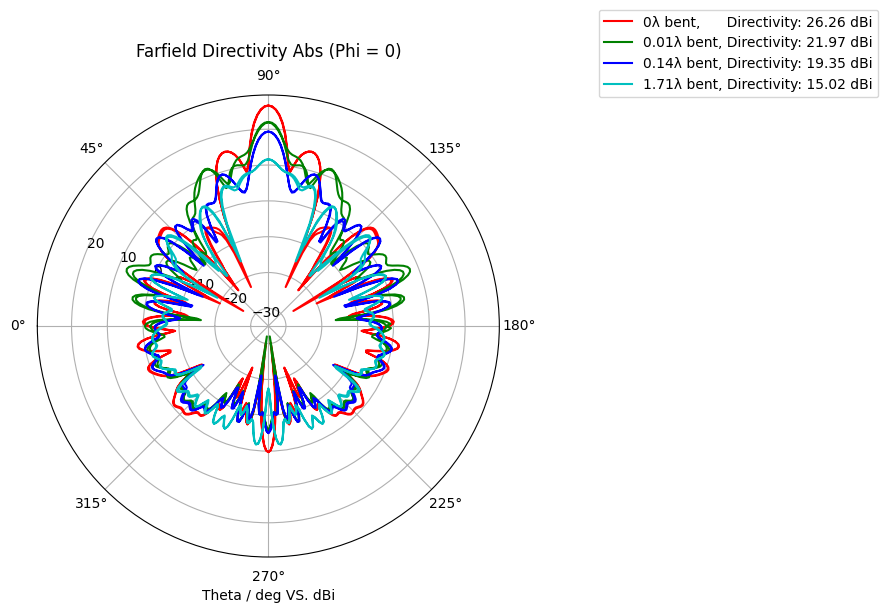

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to read and preprocess data from a file
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        theta = []
        directivity = []
        for line in lines:
            if not line.startswith('#') and line.strip():
                parts = line.split()
                theta_val = float(parts[0])
                directivity_val = float(parts[1])
                
                # Convert theta from degrees to radians
                theta_val_rad = np.radians(theta_val)
                
                # Ensure symmetry around the vertical axis (theta=90 degrees)
                if theta_val < 0:
                    # Reflect values on the left side (theta < 0)
                    theta.append(np.pi - theta_val_rad)
                    directivity.append(directivity_val)
                elif theta_val > 0:
                    # Reflect values on the right side (theta > 0)
                    theta.append(-np.pi - theta_val_rad)
                    directivity.append(directivity_val)
                
                # Original values
                theta.append(theta_val_rad)
                directivity.append(directivity_val)

    return np.array(theta), np.array(directivity)

# File paths
file_paths = ['0.txt', '30000.txt', '2610.txt', '210.txt']

# Initialize plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Colors and labels for each dataset
colors = ['r', 'g', 'b', 'c']
labels = ['0λ bent,      Directivity: 26.26 dBi', '0.01λ bent, Directivity: 21.97 dBi', '0.14λ bent, Directivity: 19.35 dBi', '1.71λ bent, Directivity: 15.02 dBi']

# Plot each dataset with symmetry
for file_path, color, label in zip(file_paths, colors, labels):
    theta, directivity = read_data(file_path)
    # Sorting the values to ensure a proper plot
    sorted_indices = np.argsort(theta)
    ax.plot(theta[sorted_indices], directivity[sorted_indices], color=color, label=label)

# Customize the plot
ax.set_title('Farfield Directivity Abs (Phi = 0)', va='bottom')
ax.set_theta_zero_location('W')  # 0 degrees at the right
ax.set_theta_direction(-1)  # Clockwise direction

# Customizing the thetagrids
ax.set_thetagrids(range(0, 360, 45), labels=[f'{angle}°' for angle in range(0, 360, 45)])

ax.set_xlabel('Theta / deg VS. dBi')
ax.grid(True)
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1.2))

# Display the plot
plt.show()



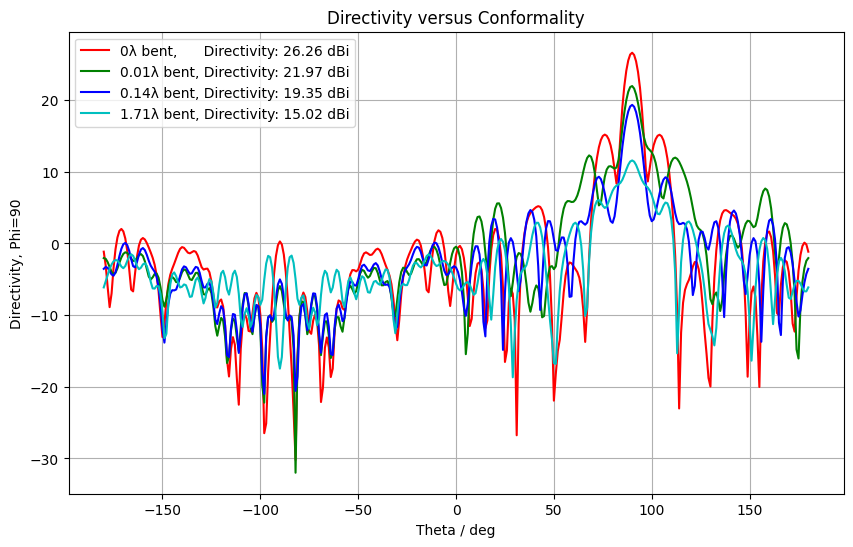

In [3]:
import matplotlib.pyplot as plt

# Function to read data from a file
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        theta = []
        directivity = []
        for line in lines:
            if not line.startswith('#') and line.strip():
                parts = line.split()
                theta.append(float(parts[0]))
                directivity.append(float(parts[1]))
    return theta, directivity

# File paths
file_paths = ['0.txt', '30000.txt', '2610.txt', '210.txt']

# Initialize plot
plt.figure(figsize=(10, 6))

# Colors and labels for each dataset
colors = ['r', 'g', 'b', 'c']
labels = ['0λ bent,      Directivity: 26.26 dBi', '0.01λ bent, Directivity: 21.97 dBi', '0.14λ bent, Directivity: 19.35 dBi', '1.71λ bent, Directivity: 15.02 dBi']

# Plot each dataset
for file_path, color, label in zip(file_paths, colors, labels):
    theta, directivity = read_data(file_path)
    plt.plot(theta, directivity, color=color, label=label)

# Customize the plot
plt.title('Directivity versus Conformality')
plt.xlabel('Theta / deg')
plt.ylabel('Directivity, Phi=90')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [4]:
#-------------------------------------------------------------------------------------------------------------
#                                       Unit cell
#-------------------------------------------------------------------------------------------------------------


import math
import numpy as np

# Constants:
c = 3e8  # Speed of light in meters per second
mu_0 = 4 * math.pi * 1e-7  # Permeability of free space in H/m
eps_0 = 8.854e-12  # Permittivity of free space in F/m

# Values we know:
substrate_height = 0.000762  # Substrate height in meters 
substrate_permittivity = 3.48  # Relative permittivity of substrate (Er)
patch_length = 0.0075  # Patch length in meters 

# Effective dielectric constant of the patch
Eeff = ((substrate_permittivity + 1) / 2) + ((substrate_permittivity - 1) / (2 * math.sqrt(1 + (12 * (substrate_height / patch_length)))))

# Effective length extension
Delta_L = 0.412 * substrate_height * ((Eeff + 0.300) / (Eeff - 0.258)) * (((patch_length / substrate_height) + 0.264) / ((patch_length / substrate_height) + 0.813))

# Effective patch length showing fringing fields at the end of the patch
Leff = patch_length + 2 * Delta_L 

# Resonant Frequency
Frequency = c / (2 * Leff * math.sqrt(Eeff))

# Wavelength
Wavelength = c / Frequency

# Patch length
Square_patch = Wavelength / 4

# Directivity (using ** for exponentiation and math.pi for π)
A = 0.30  # Converted A to meters (30 cm)
Directivity = (4 * math.pi * A) / (Wavelength ** 2)

# Gain (assuming eA is efficiency, which is typically less than 1)
eA = 1  # Efficiency
Gain = (4 * math.pi * A * eA) / (Wavelength ** 2)

# Print results
print(f"Eeff: {Eeff}")
print(f"Delta_L: {Delta_L} meters")
print(f"Leff: {Leff} meters")
print(f"Frequency: {Frequency} Hz")
print(f"Wavelength: {Wavelength} meters")
print(f"Square_patch: {Square_patch} meters")
print(f"Directivity: {Directivity}")
print(f"Gain: {Gain}")


Eeff: 3.072383500988635
Delta_L: 0.00035680658237557315 meters
Leff: 0.008213613164751147 meters
Frequency: 10418838395.666801 Hz
Wavelength: 0.02879399685523197 meters
Square_patch: 0.007198499213807993 meters
Directivity: 4547.023649037958
Gain: 4547.023649037958


In [5]:
#-------------------------------------------------------------------------------------------------------------
#                                       Designing reflectarray dimensions
#-------------------------------------------------------------------------------------------------------------

import numpy as np
from math import pi

frequency = 10e9 
wavelength_mm = 3e8 / frequency * 1000  
k0 = 2 * pi / wavelength_mm 
spacing = wavelength_mm/2

x_positions_mm = np.linspace(-spacing * 9.5, spacing * 9.5, 21)
y_positions_mm = np.linspace(-spacing * 9.5, spacing * 9.5, 21)

# Calculate Width and Height
width = np.abs(x_positions_mm[-1] - x_positions_mm[0])
height = np.abs(y_positions_mm[-1] - y_positions_mm[0])

# Calculate Area
area = width * height

spacing, x_positions_mm, y_positions_mm, width, height, area

(15.0,
 array([-142.5 , -128.25, -114.  ,  -99.75,  -85.5 ,  -71.25,  -57.  ,
         -42.75,  -28.5 ,  -14.25,    0.  ,   14.25,   28.5 ,   42.75,
          57.  ,   71.25,   85.5 ,   99.75,  114.  ,  128.25,  142.5 ]),
 array([-142.5 , -128.25, -114.  ,  -99.75,  -85.5 ,  -71.25,  -57.  ,
         -42.75,  -28.5 ,  -14.25,    0.  ,   14.25,   28.5 ,   42.75,
          57.  ,   71.25,   85.5 ,   99.75,  114.  ,  128.25,  142.5 ]),
 285.0,
 285.0,
 81225.0)

In [6]:
#-------------------------------------------------------------------------------------------------------------
#                                       Determining Phase Shift for Individual Patch Elements
#-------------------------------------------------------------------------------------------------------------

from math import sin, cos, radians, sqrt, degrees, pi
import numpy as np

# Given values
x_i = 142.5  # mm, x-coordinate of the patch
y_i = 142.5 # mm, y-coordinate of the patch
feed_point_z = 210  # mm, z-coordinate of the feed point
frequency = 10  # GHz
c = 3e8  # m/s, speed of light
theta = 30  # degrees
phi = 0  # degrees

# Convert frequency to Hz and calculate wavelength in mm
lambda_mm = (c / (frequency * 1e9)) * 1000

# Calculate wave number in mm^-1
k0 = 2 * pi / lambda_mm

# Calculate Ri, the distance from the feed point to the patch
Ri = sqrt(x_i**2 + y_i**2 + feed_point_z**2)

# Calculate the phase shift
phi_a = k0 * (Ri - sin(radians(theta)) * (x_i * cos(radians(phi)) + y_i * sin(radians(phi))))

# Convert phase shift from radians to degrees
phi_a_deg = np.degrees(phi_a)

# Normalize phase shift to degrees and ensure it is within 0-360 range
phi_a_deg_360 = degrees(phi_a) % 360

# Normalize phase shift to within -180 to 180 degree range
phi_a_deg_normalized_180 = ((phi_a_deg + 180) % 360) - 180

Ri, lambda_mm, k0, phi_a, phi_a_deg, phi_a_deg_360, phi_a_deg_normalized_180

(291.0541186789838,
 30.0,
 0.20943951023931953,
 46.03566696471163,
 2637.6494241478053,
 117.64942414780535,
 117.64942414780535)

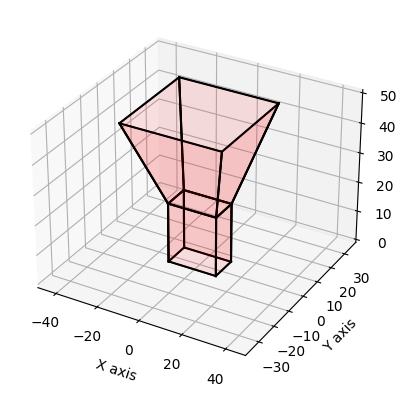

In [7]:
#-------------------------------------------------------------------------------------------------------------
#                                       Horn Antenna 
#-------------------------------------------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Given parameters
a = 22.86  # waveguide input width
b = 10.16  # waveguide input height
lam = 20   # length of the waveguide
Pe = 30    # horn flare length
a1 = 47    # horn aperture width
b1 = 37    # horn aperture height

# Define the vertices of the waveguide input and end
wg_front = np.array([
    [-a/2, -b/2, 0],
    [a/2, -b/2, 0],
    [a/2, b/2, 0],
    [-a/2, b/2, 0]
])
wg_back = wg_front + np.array([0, 0, lam])

# Define the vertices of the horn aperture
horn_flare = np.array([
    [-a1/2, -b1/2, lam + Pe],
    [a1/2, -b1/2, lam + Pe],
    [a1/2, b1/2, lam + Pe],
    [-a1/2, b1/2, lam + Pe]
])

# Create figure and 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to create edges for a more pronounced outline
def add_edges(vertices_list, color='black'):
    for i in range(len(vertices_list)):
        # Connect each vertex to the next, and the last back to the first
        ax.plot3D(*zip(*[vertices_list[i], vertices_list[(i + 1) % len(vertices_list)]]), color=color)

# Draw the sides of the waveguide and horn flare
sides = [
    [wg_back[0], wg_back[1], horn_flare[1], horn_flare[0]],
    [wg_back[1], wg_back[2], horn_flare[2], horn_flare[1]],
    [wg_back[2], wg_back[3], horn_flare[3], horn_flare[2]],
    [wg_back[3], wg_back[0], horn_flare[0], horn_flare[3]],
    # Connecting the input and output edges of the waveguide
    [wg_front[0], wg_front[1], wg_back[1], wg_back[0]],
    [wg_front[1], wg_front[2], wg_back[2], wg_back[1]],
    [wg_front[2], wg_front[3], wg_back[3], wg_back[2]],
    [wg_front[3], wg_front[0], wg_back[0], wg_back[3]]
]

ax.add_collection3d(Poly3DCollection(sides, facecolors='red', linewidths=1, edgecolors='black', alpha=0.1))

# Manually add edges to enhance the outline
for side in sides:
    add_edges(side, color='black')

# Set the aspect ratio, labels, and limits
ax.set_aspect('auto')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-a1, a1)
ax.set_ylim(-b1, b1)
ax.set_zlim(0, lam + Pe)

# Show the plot
plt.show()




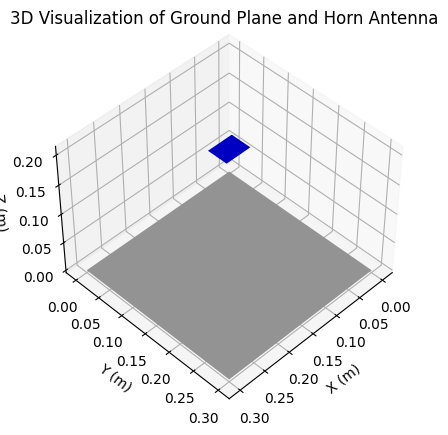

In [8]:
#-------------------------------------------------------------------------------------------------------------
#                                       Horn illuminating reflectarray (incomplete)
#-------------------------------------------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Horn Antenna Parameters
aperture_width = 0.047  # Width of the horn in meters
aperture_height = 0.037  # Height of the horn in meters
horn_position = [0.15, 0.15, 0.21]  # Position (x, y, z) in meters

# Ground Plane Parameters
ground_plane_size = 0.3  # Making the ground plane 30cm x 30cm for visibility

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot Ground Plane as a filled surface
gp_x, gp_y = np.meshgrid(np.linspace(0, ground_plane_size, 2), np.linspace(0, ground_plane_size, 2))
gp_z = np.zeros(gp_x.shape)
ax.plot_surface(gp_x, gp_y, gp_z, color='silver')  # 'silver' color for PEC

# Calculate Horn Antenna vertices for plotting as a filled object
ha_x = [horn_position[0] - aperture_width/2, horn_position[0] + aperture_width/2]
ha_y = [horn_position[1] - aperture_height/2, horn_position[1] + aperture_height/2]
ha_z = horn_position[2]

# Create meshgrid for Horn Antenna surface
ha_x_grid, ha_y_grid = np.meshgrid(ha_x, ha_y)
ha_z_grid = np.full(ha_x_grid.shape, ha_z)

# Plot Horn Antenna as a filled surface
ax.plot_surface(ha_x_grid, ha_y_grid, ha_z_grid, color='blue')

# Setting labels and aspect ratio
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Visualization of Ground Plane and Horn Antenna')

# Adjust the aspect ratio and viewing angle for better visualization
ax.set_aspect('auto')
ax.view_init(elev=45, azim=45)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7cefc256-235a-4cad-b9c8-4fdfbfe77853' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>